This is a tiny amount of scaffolding around the directed homophilic preferential attachment code written by Lisette Espin and others ([available here](https://github.com/gesiscss/Homophilic_Directed_ScaleFree_Networks)). In particular, we replicate a simple case where homophily within groups can lead to inequities between groups, defined as underrepresentation of minorities in the top k% of ranks.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from paper.DPAH import DPAH
from DPAH2 import DPAH2

In [2]:
def compute_inequity_old(g, k):
    """Compute the proportion of minorities in the top k ranks of g"""
    node_pageranks = nx.pagerank(g)
    node_pageranks_sorted = sorted(node_pageranks.items(), key=lambda x: x[1], reverse=True)
    top_k = node_pageranks_sorted[:k]
    
    num_top_k_minority = sum([g.nodes[node_id]['m'] for (node_id, _) in top_k])
    
    return num_top_k_minority / k    

In [3]:
def compute_inequity(g, k):
    """Compute the proportion of allies and minorities in the top k ranks of g"""
    node_pageranks = nx.pagerank(g)
    node_pageranks_sorted = sorted(node_pageranks.items(), key=lambda x: x[1], reverse=True)
    top_k = node_pageranks_sorted[:k]
    
    num_top_k_allies = 0
    num_top_k_minority = 0
    
    for (node_id, _) in top_k:
        if g.nodes[node_id]['m'] == 1: # is an ally:
            num_top_k_allies += 1
        elif g.nodes[node_id]['m'] == 2: # is minority
            num_top_k_minority += 1
    
    return num_top_k_allies / k, num_top_k_minority / k

In [4]:
# Number of nodes
N = 1000

# Top beta% of rankings to consider for inequity
beta = 0.05

# Top k nodes to consider for inequity. k = N * beta
k = int(N * beta)

# Fraction minority
fm = 0.2

# Fraction allies
fa = 0

# homophily within majority group
h_MM = 0.8

# homophily within minority group
h_mm = 0.8

print(k)

50


In [30]:
start = time.time()

results = []

for i in range(3):
    g = DPAH(N=N, fm=fm, d=0.0015, plo_M=3, plo_m=3, h_MM=h_MM, h_mm=h_mm, verbose=False, seed=i)
    prop_top_k_minority = compute_inequity_old(g, k)
    results.append(prop_top_k_minority)
    
end = time.time()

end - start

15.626109838485718

In [29]:
results

[0.1, 0.12, 0.08]

With strong homophily (h_MM=h_mm=0.8), in all five runs minorities are underrepresented in the top 5% (50) of ranks. In particular, with equity, we'd expect an average representation of 20% in the top ranks.

In [ ]:
results = []

for fraction_allies in np.linspace(0, 0.5 - fm, 20):
    for i in range(20):
        g = DPAH2(
            N=N,
            fm=fm,
            fa=fraction_allies, # Fraction that are allies
            d=0.0015,
            plo_M=3,
            plo_m=3,
            h_MM=h_MM,
            h_mm=h_mm,
            verbose=False,
            seed=i)
        
        prop_top_k_ally, prop_top_k_minority = compute_inequity(g, k)
        results.append((fraction_allies, prop_top_k_ally, prop_top_k_minority))
        print((fraction_allies, prop_top_k_ally, prop_top_k_minority))

(0.0, 0.0, 0.06)
(0.0, 0.0, 0.14)
(0.0, 0.0, 0.08)
(0.0, 0.0, 0.14)
(0.0, 0.0, 0.06)
(0.0, 0.0, 0.02)
(0.0, 0.0, 0.16)
(0.0, 0.0, 0.16)
(0.0, 0.0, 0.1)
(0.0, 0.0, 0.08)
(0.0, 0.0, 0.06)
(0.0, 0.0, 0.08)


In [ ]:
df_results = pd.DataFrame(results, columns=['prop_ally', 'prop_ally_top_k', 'prop_min_top_k'])
df_results.to_csv("group_A/results/ally_sweep.csv", index=False)
df_results

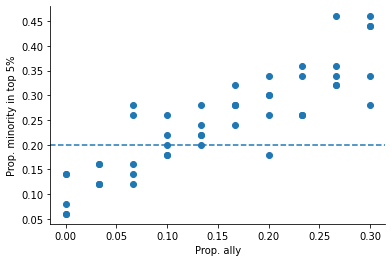

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(df_results.prop_ally, df_results.prop_min_top_k)
ax.set_xlabel("Prop. ally")
ax.set_ylabel("Prop. minority in top 5%")
ax.axhline(0.2, linestyle='--')

sns.despine()

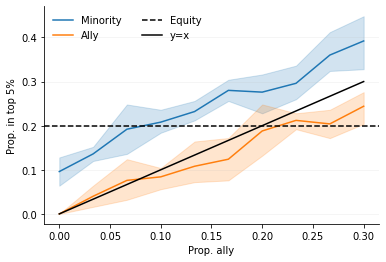

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(data=df_results, x='prop_ally', y='prop_min_top_k', label='Minority')
sns.lineplot(data=df_results, x='prop_ally', y='prop_ally_top_k', label='Ally')

ax.set_xlabel("Prop. ally")
ax.set_ylabel("Prop. in top 5%")
ax.axhline(0.2, linestyle='--', color='black', label='Equity')
ax.plot([0, 0.3], [0, 0.3], color='black', label='y=x')

ax.legend(frameon=False, ncol=2)

sns.despine()
ax.yaxis.grid(alpha=0.15)

Parameter sweep over the proportion of minorities who are "covert".

In [ ]:
results_covert = []

for fraction_covert in np.linspace(0, fm, 20):
    for i in range(20):
        g = DPAH2(
            N=N,
            fm=fm - fraction_covert,
            fa=fraction_covert, # "Allies" and "covert" are functionally the same
            d=0.0015,
            plo_M=3,
            plo_m=3,
            h_MM=h_MM,
            h_mm=h_mm,
            verbose=False,
            seed=i)

        prop_top_k_covert, prop_top_k_minority = compute_inequity(g, k)
        results_covert.append((fraction_covert, prop_top_k_covert, prop_top_k_minority))
        print((fraction_covert, prop_top_k_covert, prop_top_k_minority))

In [ ]:
df_results_covert = pd.DataFrame(results_covert, columns=['prop_covert', 'prop_covert_top_k', 'prop_overt_top_k'])
df_results_covert['prop_covert_rescaled'] = df_results_covert['prop_covert'] / df_results_covert['prop_covert'].max()
df_results_covert['prop_all_minorities_top_k'] = df_results_covert['prop_covert_top_k'] + df_results_covert['prop_overt_top_k']

df_results_covert.to_csv("group_A/results/covert_sweep.csv", index=False)

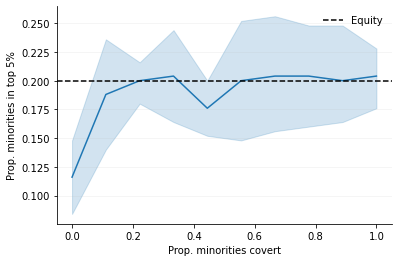

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(data=df_results_covert, x='prop_covert_rescaled', y='prop_all_minorities_top_k')

ax.set_xlabel("Prop. minorities covert")
ax.set_ylabel("Prop. minorities in top 5%")
ax.axhline(0.2, linestyle='--', color='black', label='Equity')

ax.legend(frameon=False, ncol=2)

sns.despine()
ax.yaxis.grid(alpha=0.15)